Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Vector Quantized Variational Autoencoders for 3D reconstruction of images

This tutorial illustrates how to use MONAI for training a Vector Quantized Variational Autoencoder (VQVAE)[1] on 3D images.

Here, we will train our VQVAE model to be able to reconstruct the input images.  We will work with the Decathlon Dataset available on [MONAI](https://docs.monai.io/en/stable/apps.html#monai.apps.DecathlonDataset). In order to train faster, we will select just one of the available tasks ("Task01_BrainTumour").

The VQVAE can also be used as a generative model if an autoregressor model (e.g., PixelCNN, Decoder Transformer) is trained on the discrete latent representations of the VQVAE bottleneck. This falls outside of the scope of this tutorial.

[1] - Oord et al. "Neural Discrete Representation Learning" https://arxiv.org/abs/1711.00937


### Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch.nn import L1Loss

from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism, ensure_tuple
from monai.networks.nets import VQVAE

print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.4.0rc6
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a0e1b043ba2890e1463fa49df76f66e56a68b08
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.0
pynrrd version: 1.0.0
clearml version: 1.16.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

../data


### Setup used transforms and download dataset

In [5]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

In [6]:
batch_size = 16
num_workers = 8

train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform, section="training", download=True
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform, section="validation", download=True
)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

2024-09-05 22:11:47,598 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-09-05 22:11:47,600 - INFO - File exists: ../data/Task01_BrainTumour.tar, skipped downloading.
2024-09-05 22:11:47,602 - INFO - Non-empty folder exists in ../data/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 388/388 [04:57<00:00,  1.30it/s]


2024-09-05 22:16:58,676 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-09-05 22:16:58,678 - INFO - File exists: ../data/Task01_BrainTumour.tar, skipped downloading.
2024-09-05 22:16:58,679 - INFO - Non-empty folder exists in ../data/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


### Visualize the training images

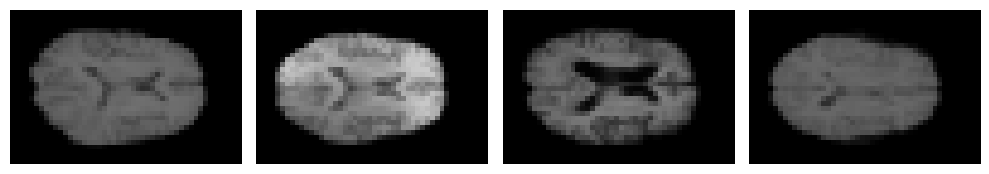

In [7]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, optimizer and losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(256, 256),
    num_res_channels=256,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=256,
    embedding_dim=32,
).to(device)

Using cuda:2


In [9]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
l1_loss = L1Loss()

### Model training
Here, we are training our model for 100 epochs (training time: ~60 minutes).

In [10]:
max_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_quant_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = model(images=images)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_quant_loss_list.append(quantization_loss.item() / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)

                # get the first sample from the first validation batch for
                # visualizing how the training evolves
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 3: 100%|█████████████████| 25/25 [00:06<00:00,  3.76it/s, recons_loss=0.0416, quantization_loss=7.17e-6]
...
Epoch 99: 100%|████████████████| 25/25 [00:06<00:00,  3.96it/s, recons_loss=0.0085, quantization_loss=2.13e-6]


train completed, total time: 653.6743619441986.


### Learning curves

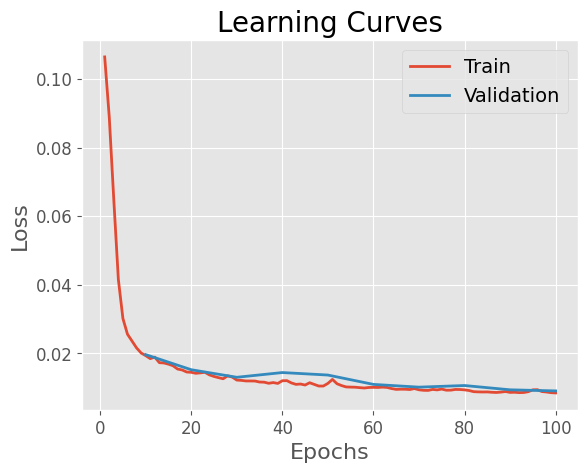

In [11]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

###  Plotting  evolution of reconstructed images

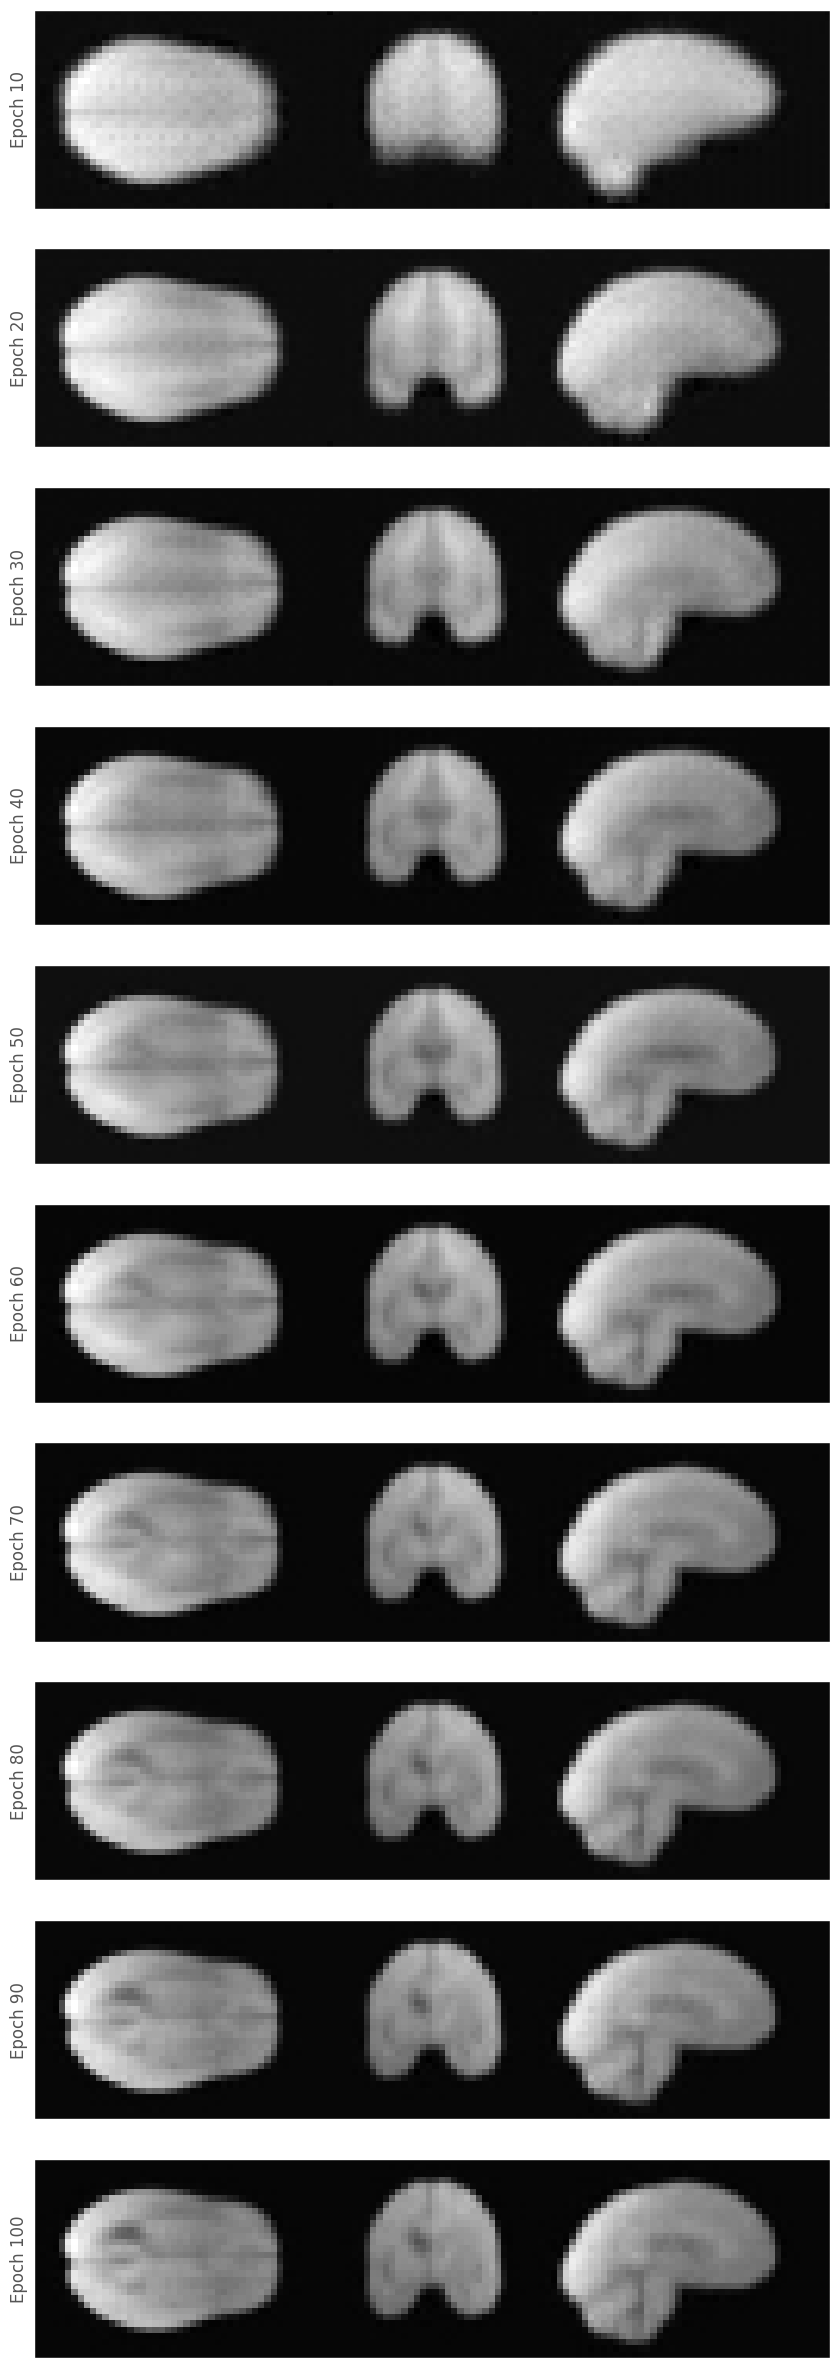

In [12]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(18.5, 30.5)
ax = ensure_tuple(ax)

for image_n in range(len(val_samples)):
    reconstructions = intermediary_images[image_n]
    reconstructions = np.concatenate(
        [
            reconstructions[0, :, :, 15],
            np.flipud(reconstructions[0, :, 24, :].T),
            np.flipud(reconstructions[0, 15, :, :].T),
        ],
        axis=1,
    )

    ax[image_n].imshow(reconstructions, cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

### Plotting the reconstructions from final trained model

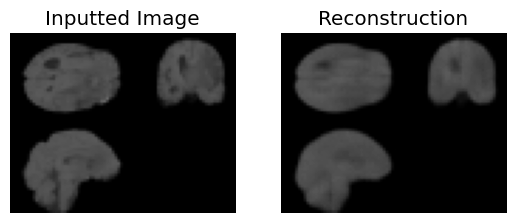

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.style.use("default")
plotting_image_0 = np.concatenate([images[0, 0, :, :, 15].cpu(), np.flipud(images[0, 0, :, 24, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(images[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
image = np.concatenate([plotting_image_0, plotting_image_1], axis=0)

ax[0].imshow(image, vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")

plotting_image_2 = np.concatenate(
    [reconstruction[0, 0, :, :, 15].cpu(), np.flipud(reconstruction[0, 0, :, 24, :].cpu().T)], axis=1
)
plotting_image_3 = np.concatenate([np.flipud(reconstruction[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
reconstruction_3d = np.concatenate([plotting_image_2, plotting_image_3], axis=0)
ax[1].imshow(reconstruction_3d, vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)